# Variational Auto Encoder
_____

普通の Auto Encoder と違って潜在空間に正規分布を仮定する
Encoder の出力を 平均と分散パラメータにし，それをもとに正規分布乱数生成したものを Decoder に入れる

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
%matplotlib inline

sns.set()
%config InlineBackend.figure_formats = {'png', 'retina'}

### データの読み込み

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

# 画像を読み込んだ時の変換関数を作る
tfm = transforms.Compose([transforms.ToTensor()]) # 画像はすでに[0, 1]正規化されている
# それぞれのデータと読み込み方を指定
trainset = torchvision.datasets.MNIST(root='../../data', train=True, download=True, transform=tfm)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='../../data', train=False, download=True, transform=tfm)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                          shuffle=True, num_workers=2)


#### GPU が使えるなら使う

In [0]:
def try_gpu(e):
    if torch.cuda.is_available():
        return e.cuda()
    return e

### ネットワークを作る

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.fc1 = nn.Linear(28**2, 50)    # 28*28 -> 50
        self.bn1 = nn.BatchNorm1d(50)
        self.Sigmoid = nn.Sigmoid()
        self.mean = nn.Linear(50, z_dim)   # 50 -> z_dim
        self.log_var = nn.Linear(50, z_dim)

    def forward(self, x):
        x = x.view(-1, 28**2)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.Sigmoid(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        var = torch.exp(log_var)  # nonnegative
        return mean, var


class Decoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.fc1 = nn.Linear(z_dim, 50)
        self.sigmoid1 = nn.Sigmoid()
        self.fc2 = nn.Linear(50, 28**2)
        self.sigmoid2 = nn.Sigmoid()
        # self.hardtanh = nn.Hardtanh(min_val=-0.01, max_val=1.01)

    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid1(x)
        x = self.fc2(x)
        x = self.sigmoid2(x)
        x = x.view(-1, 1, 28, 28)
        return x


class VAE(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)

    def forward(self, x):
        mean, var = self.encoder(x)
        z = mean + torch.sqrt(var) * torch.randn_like(var)
        y = self.decoder(z)
        return y, mean, var


z_dim = 2
vae = try_gpu(VAE(z_dim))
print(vae)

VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=784, out_features=50, bias=True)
    (bn1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Sigmoid): Sigmoid()
    (mean): Linear(in_features=50, out_features=2, bias=True)
    (log_var): Linear(in_features=50, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=2, out_features=50, bias=True)
    (sigmoid1): Sigmoid()
    (fc2): Linear(in_features=50, out_features=784, bias=True)
    (sigmoid2): Sigmoid()
  )
)


### Loss関数の定義
Encoderの分散も大きくなりすぎないように正規化項をつける



In [0]:
def criterion(original, reconst, mean, var, eps=0.0):
    mle_loss_function = nn.MSELoss(reduction="mean")   # 画像は2乗誤差 
    mle_loss = mle_loss_function(reconst, original)
    # KL divergence KL[N(mean, var) | N(0, 1)]
    kld_loss = -0.5 * torch.mean(torch.sum(1 + torch.log(var) - mean**2 - var, axis=1))

    return mle_loss + eps * kld_loss

### 最適化手法の定義

In [0]:
import torch.optim as optim

optimizer = optim.Adam(vae.parameters(), lr=0.01)

### 学習する

1 / epoch 600 roop  loss: 0.3457077891007066
2 / epoch 600 roop  loss: 0.3065548412874341
3 / epoch 600 roop  loss: 0.28856930587440727
4 / epoch 600 roop  loss: 0.27949605099856856
5 / epoch 600 roop  loss: 0.27305116213858127
6 / epoch 600 roop  loss: 0.2692757073789835
7 / epoch 600 roop  loss: 0.26638903848826884
8 / epoch 600 roop  loss: 0.263933555483818
9 / epoch 600 roop  loss: 0.2618412309885025
10 / epoch 600 roop  loss: 0.26053963143378495
11 / epoch 600 roop  loss: 0.25920818265527484
12 / epoch 600 roop  loss: 0.25759234234690664
13 / epoch 600 roop  loss: 0.25691338017582893
14 / epoch 600 roop  loss: 0.2555770187452435
15 / epoch 600 roop  loss: 0.2550111063942313
16 / epoch 600 roop  loss: 0.254266722984612
17 / epoch 600 roop  loss: 0.2536827125027776
18 / epoch 600 roop  loss: 0.2527812842652202
19 / epoch 600 roop  loss: 0.25201203264296057
20 / epoch 600 roop  loss: 0.2517459066212177
21 / epoch 600 roop  loss: 0.251148500777781
22 / epoch 600 roop  loss: 0.25078079

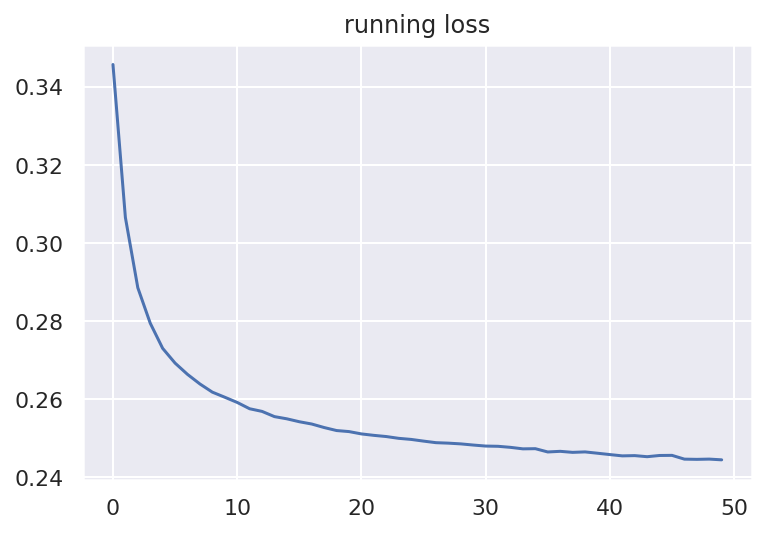

CPU times: user 3min 16s, sys: 14.4 s, total: 3min 30s
Wall time: 5min 52s


In [7]:
%%time
vae.train()
running_losses = []

for epoch in range(50):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, start=1): 
        inputs = try_gpu(inputs)
        labels = try_gpu(labels)

        # 計算していた逆伝播を0に戻す
        optimizer.zero_grad()

        # forward / backward / optimize
        outputs, mean, var = vae(inputs)
        loss = criterion(inputs, outputs, mean, var, eps=0.0001)  # データを損失関数に突っ込む
        loss.backward()    # 誤差逆伝播(パラメータの変化の微分を計算)
        optimizer.step()   # 最適化手法をもとにパラメータ更新

        # print statistics
        running_loss += loss.item()
        if i % 600 == 0:    # print every 200 mini-batches (1バッチは100枚 trainデータは60000枚あるので600までいく)
            running_loss_mean = running_loss / 100
            print(f'{epoch+1} / epoch {i} roop  loss: {running_loss_mean}', flush=True)
            running_losses.append(running_loss_mean)
            running_loss = 0.0
print('Finished Training')

plt.plot(running_losses)
plt.title("running loss")
plt.show()

### 再構成画像との比較

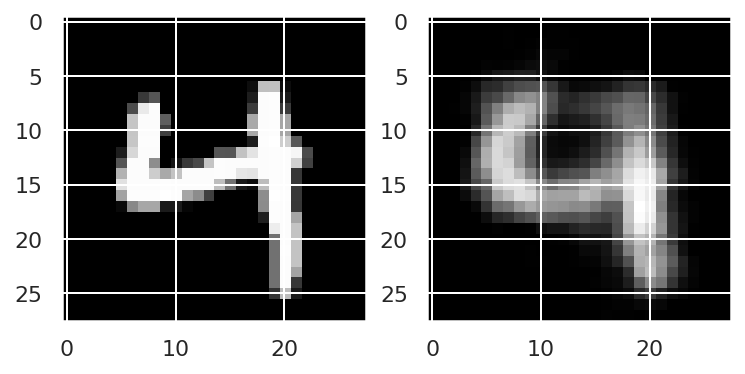

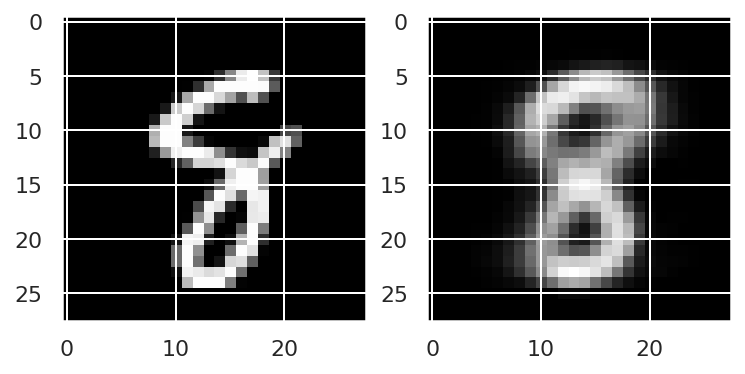

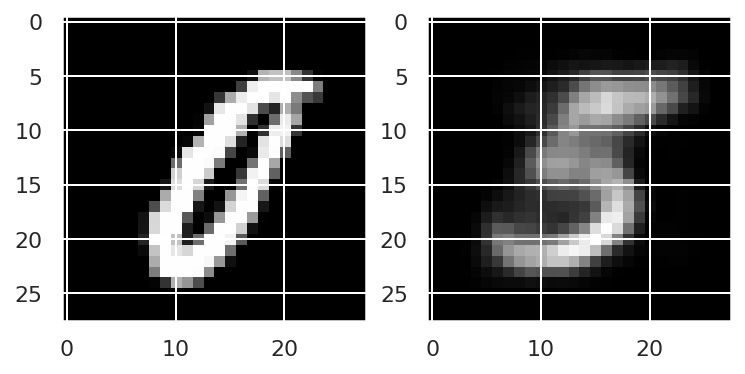

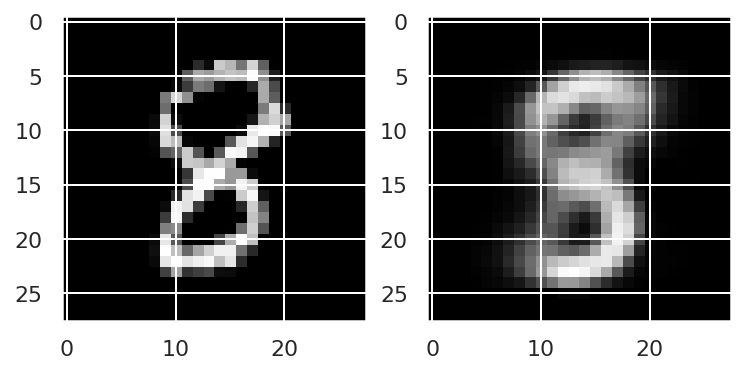

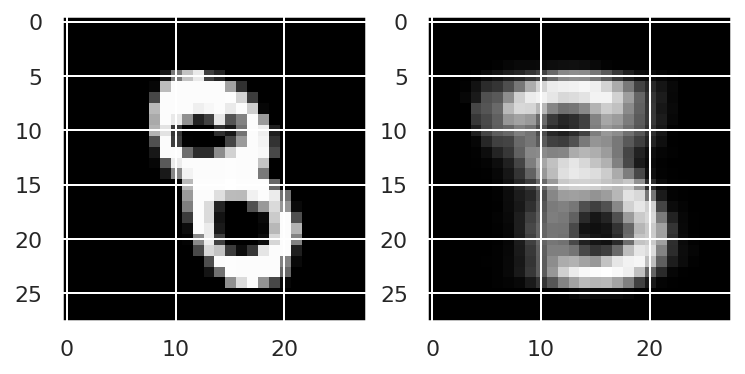

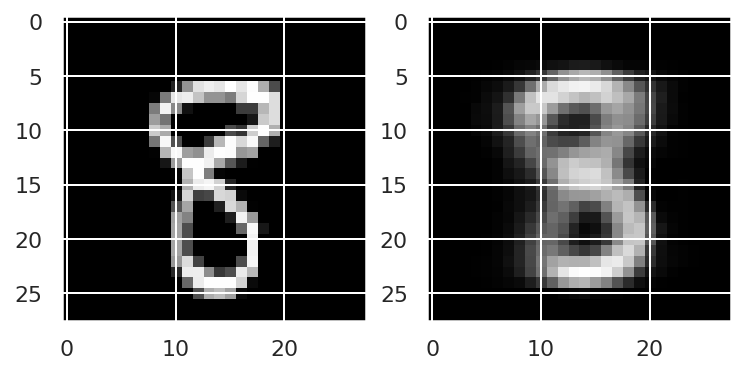

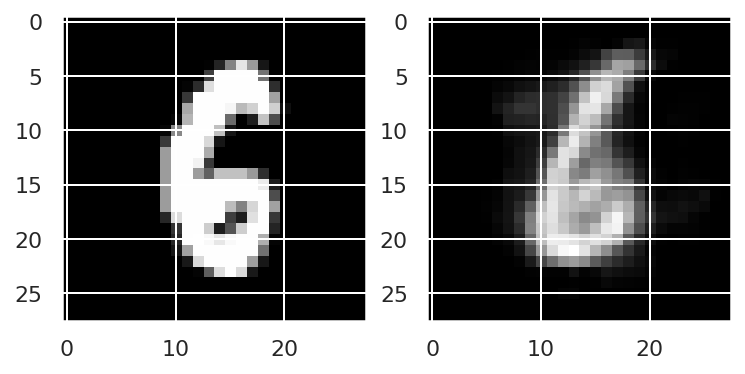

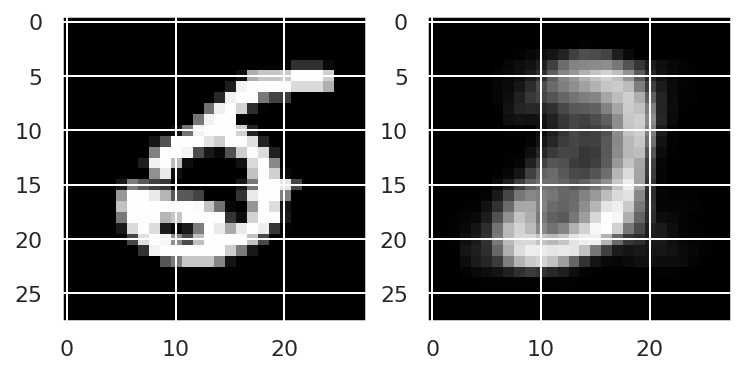

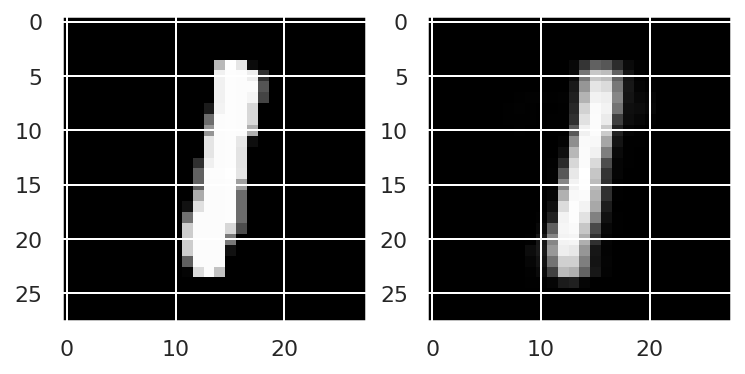

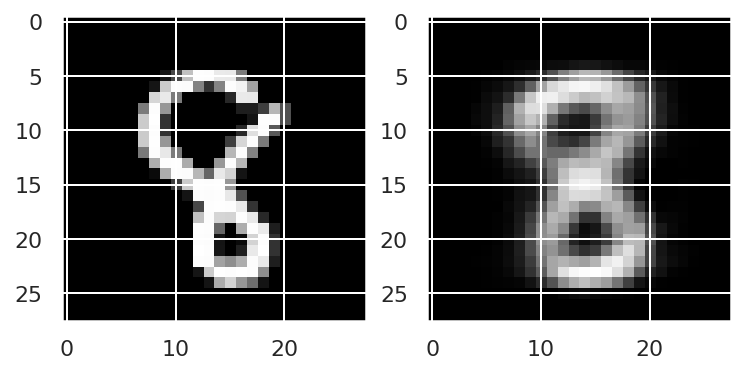

In [8]:
vae.eval()

each_testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                          shuffle=True, num_workers=2)

dataiter = iter(each_testloader) 
with torch.no_grad():
     for epoch in range(10):
# plt.figure(figsize=(10,5))
        inputs, label = dataiter.next()
        inputs, label = try_gpu(inputs), try_gpu(label)

        outputs, mean, var = vae(inputs)
        inputs = inputs.cpu().reshape(28, 28) 
        outputs = outputs.cpu().reshape(28, 28)
        plt.subplot(1, 2, 1)
        plt.imshow(inputs, cmap="gray")
        plt.subplot(1, 2, 2)
        plt.imshow(outputs, cmap="gray")
        plt.show()

In [9]:
%%time
vae.eval()
all_labels = []
all_means = []
all_vars = []

with torch.no_grad(): 
    for images, labels in testloader:
        images, labels = try_gpu(images), try_gpu(labels)
        outputs, mean, var = vae(images)
        all_labels.append(labels)
        all_means.append(mean)
        all_vars.append(var)

all_labels = torch.cat(all_labels).cpu()
all_means = torch.cat(all_means).cpu()
all_vars = torch.cat(all_vars).cpu()

CPU times: user 187 ms, sys: 110 ms, total: 298 ms
Wall time: 1.06 s


`z_dim = 2` にしたのでプロットできる

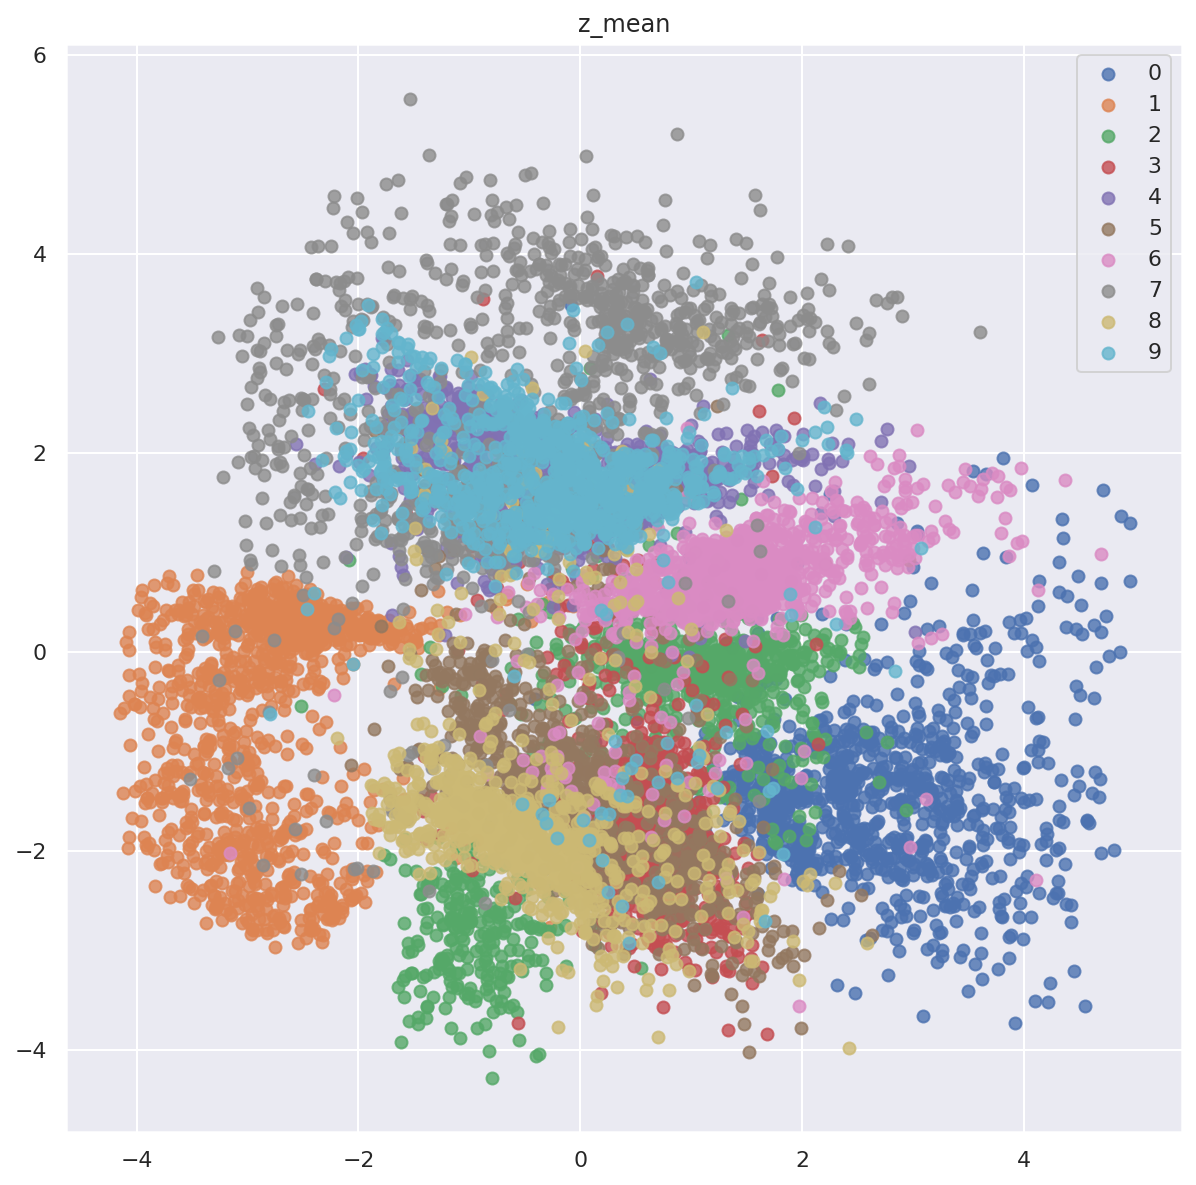

In [12]:
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.scatter(all_means[:, 0][all_labels==i], all_means[:, 1][all_labels==i], alpha=0.8, label=i)
plt.title("z_mean")
plt.legend()
plt.show()

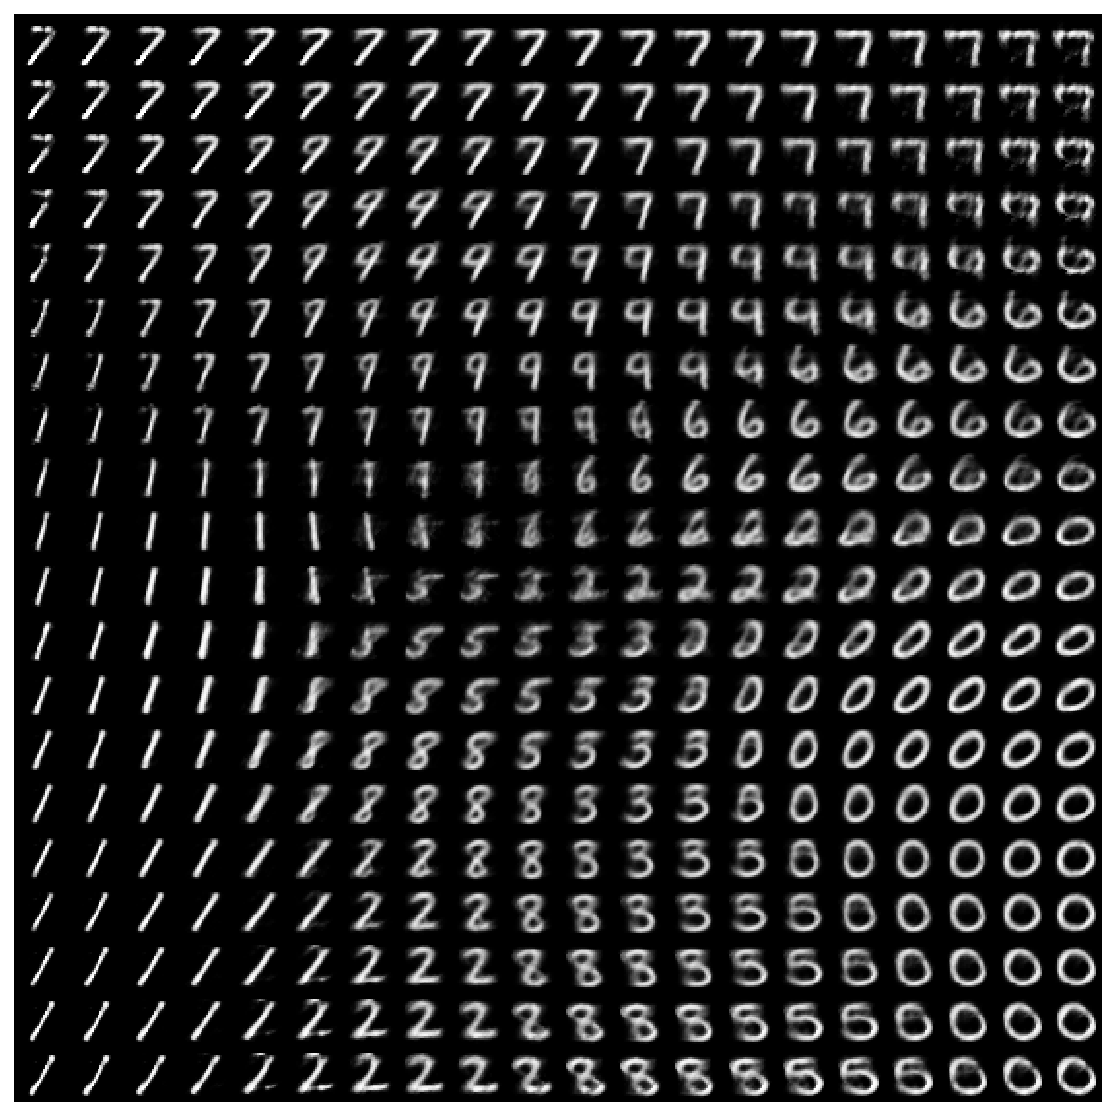

CPU times: user 801 ms, sys: 10.9 ms, total: 812 ms
Wall time: 819 ms


In [13]:
%%time
vae.eval()
X = 4
Y = 4
num = 20

xs = np.linspace(-X, X, num)
ys = np.linspace(-Y, Y, num)
i = 0
all_outputs = []
with torch.no_grad():
    for y in ys[::-1]:
        outputs = []
        for x in xs:
            i += 1
            z = torch.Tensor([x, y]).view(-1, 2)
            z = try_gpu(z)
            output = vae.decoder(z).reshape(28, 28)
            outputs.append(output)
        outputs = torch.cat(outputs, dim=1)
        all_outputs.append(outputs)
    all_outputs = torch.cat(all_outputs, dim=0).cpu()

    plt.figure(figsize=(10, 10))
    plt.imshow(all_outputs, cmap="gray")
    plt.axis("off")
    plt.show()
